# Autoencoder

## Chargement des données MNIST

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist/", one_hot=True)

# Load data
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

W1003 18:40:55.846533 4516353472 deprecation.py:323] From <ipython-input-1-9c48f15a73a7>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W1003 18:40:55.848230 4516353472 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W1003 18:40:55.849133 4516353472 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:

Extracting ./mnist/train-images-idx3-ubyte.gz


W1003 18:40:56.072629 4516353472 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W1003 18:40:56.074912 4516353472 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W1003 18:40:56.121720 4516353472 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future v

Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
x_train:  (55000, 784)
y_train:  (55000, 10)
x_test:  (10000, 784)
y_test:  (10000, 10)


* Visualisation des données

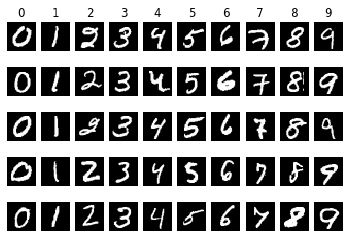

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def plot_mnist(data, classes):
    
    for i in range(10):
        idxs = (classes == i)
        
        # get 10 images for class i
        images = data[idxs][0:10]
            
        for j in range(5):   
            plt.subplot(5, 10, i + j*10 + 1)
            plt.imshow(images[j].reshape(28, 28), cmap='gray')
            # print a title only once for each class
            if j == 0:
                plt.title(i)
            plt.axis('off')
    plt.show()

classes = np.argmax(y_train, 1)
plot_mnist(x_train, classes)

## Application de l'algorithme 

On utilise Tensorflow pour construire et entraîner notre autoencoder. 
* D'abord, on construit le graphe de notre réseau de neurones. Celui-ci aura l'architecture suivante :

Entrée de 784 cellules (nombre de pixels d'une image)

Une couche de [dropout (Hinton et al. 2014)](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) est appliquée pour masquer certains pixels de l'image d'entrée afin d'éviter que certains neurones aient trop d'importance sur la reconstruction (overfitting). On appelle ce type d'autoencoder un ["Denoising Autoencoder"](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf).

Encoder : Deux couches cachées composées respectivement 600 et 300 neurones

Vecteur latent : 3 neurones

Decoder : Deux couches cachées composées respectivement 300 et 600 neurones

Sortie de 784 cellules (nombre de pixels d'une image)


__Fonctionnement :__

Les neurones de chaque couche sont connectés à chaque neurones de la couche suivante (resp. précédente) par des poids (notés w). Le rôle d'un neurone est d'appliquer une fonction non-linéaire (ici l'opérateur tanh ou tangente hyperbolique) à son entrée, qui est une somme des sorties des neurones de la couche précédente pondérée par chaque poids w à laquelle on ajoute une constante propre à chaque neurone appellée biais. 

Ici, le réseau est entraîné à reconstruire l'image d'entrée en trouvant un ensemble de poids inter-couches minimisant l'erreur de reconstruction entre la sortie du réseau et l'image d'origine. 

Pour celà on définit une fonction de perte qui est la moyenne du carré des écarts entre entre la sortie et l'entrée de l'autoencoder. Celle-ci sera minimisée par rapport à w à l'aide d'une [descente de gradient stochastique](http://eric.univ-lyon2.fr/~ricco/cours/slides/gradient_descent.pdf).


![Denoising autoencoder](https://lilianweng.github.io/lil-log/assets/images/denoising-autoencoder-architecture.png)


### Paramètres du modèle

In [3]:
# Nombre de cellules en entrée (nombre de pixels d'une image): 
number_inputs = 28 * 28

# Nombre de neurones sur la première couche de l'encodeur et dernière couche du décodeur
number_neurons_hidden_1 = 64 

# Nombre de neurones sur la deuxième couche de l'encodeur et première couche du décodeur
number_neurons_hidden_2 = 32

# Nombre de neurones sur la deuxième couche de l'encodeur et première couche du décodeur
number_neurons_hidden_3 = 16

# Taux d'apprentissage de la descente de gradient
learning_rate = 0.0001

# Nombre d'itérations à l'entraînement
number_training_epochs = 100

# Taille du batch : Nombre d'images à coonsidérer pour chaque itération
train_batch_size = 64

# Niveau de corruption : taux de pixels à masquer sur une image pour contrôler le débruitage
corruption_level = 0.1

import tensorflow as tf

# Création des poids et biais à l'aide de variables Tensorflow
weights = {
'encoder_weights_1': tf.Variable(tf.random_normal([number_inputs, number_neurons_hidden_1])),
'encoder_weights_2': tf.Variable(tf.random_normal([number_neurons_hidden_1, number_neurons_hidden_2])),
'encoder_weights_3': tf.Variable(tf.random_normal([number_neurons_hidden_2, number_neurons_hidden_3])),
'decoder_weights_1': tf.Variable(tf.random_normal([number_neurons_hidden_3, number_neurons_hidden_2])),
'decoder_weights_2': tf.Variable(tf.random_normal([number_neurons_hidden_2, number_neurons_hidden_1])),
'decoder_weights_3': tf.Variable(tf.random_normal([number_neurons_hidden_1, number_inputs]))
}
                                            
biases = {
'encoder_biases_1': tf.Variable(tf.random_normal([number_neurons_hidden_1])),
'encoder_biases_2': tf.Variable(tf.random_normal([number_neurons_hidden_2])),
'encoder_biases_3': tf.Variable(tf.random_normal([number_neurons_hidden_3])),
'decoder_biases_1': tf.Variable(tf.random_normal([number_neurons_hidden_2])),
'decoder_biases_2': tf.Variable(tf.random_normal([number_neurons_hidden_1])),
'decoder_biases_3': tf.Variable(tf.random_normal([number_inputs]))
}

### Création de l'autoencoder par couches

* Encoder

In [4]:
def create_encoder(encoder_inputs):
    encoder_layer_1 = tf.nn.tanh(tf.add(tf.matmul(encoder_inputs, weights['encoder_weights_1']),
                                        biases['encoder_biases_1']))

    encoder_layer_2 = tf.nn.tanh(tf.add(tf.matmul(encoder_layer_1, weights['encoder_weights_2']),
                                        biases['encoder_biases_2']))
    
    encoder_layer_3 = tf.nn.tanh(tf.add(tf.matmul(encoder_layer_2, weights['encoder_weights_3']),
                                        biases['encoder_biases_3']))
    
    return encoder_layer_3

* Decoder

In [5]:
def create_decoder(decoder_inputs):
    decoder_layer_1 = tf.nn.tanh(tf.add(tf.matmul(decoder_inputs, weights['decoder_weights_1']),
                                   biases['decoder_biases_1']))

    decoder_layer_2 = tf.nn.tanh(tf.add(tf.matmul(decoder_layer_1, weights['decoder_weights_2']),
                                   biases['decoder_biases_2']))
    
    decoder_layer_3 = tf.nn.tanh(tf.add(tf.matmul(decoder_layer_2, weights['decoder_weights_3']),
                                   biases['decoder_biases_3']))
    
    return decoder_layer_3

* Autoencoder complet

In [6]:
autoencoder_inputs = tf.placeholder("float", [None, number_inputs])

#On applique un masque afin de "désactiver" certains pixels de l'image en entrée
mask = tf.placeholder("float", [None, number_inputs], name='mask')
autoencoder_inputs_corrupted = autoencoder_inputs * mask

encoder_model = create_encoder(autoencoder_inputs_corrupted)
decoder_model = create_decoder(encoder_model)

y_prediction = decoder_model

y_true = autoencoder_inputs 

### Fonction de perte à minimiser

* Comme expliqué plus haut, nous cherchons à minimiser le carré de l'écart entre la valeur réelle et la valeur prédite. Pour cela, nous définissons d'abord une fonction mesurant cet écart. Plus celle-ci prend une valeur faible, et plus l'autoencoder est performant en terme de reconstruction. 

In [7]:
loss_rmse = tf.reduce_mean(tf.pow(y_true - y_prediction, 2))

* Puis, nous utiliserons l'algorithme [RMSProp](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) pour minimiser cette fonction.

In [8]:
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss_rmse)

W1003 18:41:17.083271 4516353472 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1003 18:41:17.157880 4516353472 deprecation.py:506] From /anaconda3/lib/python3.7/site-packages/tensorflow/python/training/rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Entraînement

On lance maintenant la boucle d'entraînement afin d'initialiser les valeurs de chaque variable tensorflow (ou tenseurs) définies précédemment et de lancer l'entraînement.

L'ensemble des tenseurs et opérations définis plus haut forme un Graph, l'étape d'initialisation consiste tout simplement à assigner des valeurs réelles (les données ainsi que les poids / biais aléatoirement initialisés) aux valeurs symboliques (tenseurs) et lancer les opérations sur celles-ci.

Ici, les opérations sont :

* Création des mini-batch de données par échantillonnage pour chaque itération
* Application du masque aux mini-batchs de données
* Bruitage des données par application du masque
* Pour chaque epoch : tentative de reconstruction de l'image par encodage et décodagee, calcul de l'erreur de reconstruction et de son gradient par rapport aux poids et biais (forward pass) puis mise à jour des poids et biais en soustrayant une partie de ce gradient à chaque poids / biais (backward pass).

In [9]:
var_initializer = tf.global_variables_initializer()

with tf.Session() as session:
    session.run(var_initializer)
    number_batches = int(x_train.shape[0]/train_batch_size)
    # Training cycle
    for epoch in range(number_training_epochs):
        # Iterations over all transaction batches
        for i in range(number_batches):
            # Random selection of transactions in train subset to build the mini-batch
            index_batch = np.random.choice(x_train.shape[0], train_batch_size)
            batch_transactions = x_train[index_batch]
            mask_np = np.random.binomial(1, 1 - corruption_level, batch_transactions.shape)
            # Run of the model, which performs:
            #       - loss calculation
            #       - optimization of weights and biases values, by using gradient descent
            optimization, loss = session.run(
                [optimizer, loss_rmse], feed_dict={autoencoder_inputs: batch_transactions, mask: mask_np})

        print("Epoch:", '%02d' % (epoch + 1), " -  loss = ", "{:.4f}".format(loss))

    print("Fin de l'entraînement, bon autoencodage ! \n")

Epoch: 01  -  loss =  0.9859
Epoch: 02  -  loss =  0.9351
Epoch: 03  -  loss =  0.8632
Epoch: 04  -  loss =  0.7973
Epoch: 05  -  loss =  0.6644
Epoch: 06  -  loss =  0.3819
Epoch: 07  -  loss =  0.2674
Epoch: 08  -  loss =  0.2456
Epoch: 09  -  loss =  0.2442
Epoch: 10  -  loss =  0.2354
Epoch: 11  -  loss =  0.2312
Epoch: 12  -  loss =  0.2249
Epoch: 13  -  loss =  0.2290
Epoch: 14  -  loss =  0.2303
Epoch: 15  -  loss =  0.2273
Epoch: 16  -  loss =  0.2214
Epoch: 17  -  loss =  0.2214
Epoch: 18  -  loss =  0.2270
Epoch: 19  -  loss =  0.2228
Epoch: 20  -  loss =  0.2189
Epoch: 21  -  loss =  0.2193
Epoch: 22  -  loss =  0.2243
Epoch: 23  -  loss =  0.2186
Epoch: 24  -  loss =  0.2197
Epoch: 25  -  loss =  0.2152
Epoch: 26  -  loss =  0.2208
Epoch: 27  -  loss =  0.2151
Epoch: 28  -  loss =  0.2177
Epoch: 29  -  loss =  0.2174
Epoch: 30  -  loss =  0.2151
Epoch: 31  -  loss =  0.2132
Epoch: 32  -  loss =  0.2133
Epoch: 33  -  loss =  0.2147
Epoch: 34  -  loss =  0.2147
Epoch: 35  -  

A tester : Visualisation de l'espace latent (sortie de la dernière couche de l'encoder) et des images encodées. Ré-entrainement de l'autoencoder avec un espace latent de deux ou trois dimensions et visualisation par label afin de comparer les résultat avec une ACP.